# Chapter 4: Granger Causality Test

In the first three chapters, we discussed the classical methods for both univariate and multivariate time series forecasting. We now introduce the notion of causality and its implications on time series analysis in general. We also describe a test for the linear VAR model discussed in the previous chapter.

Prepared by: Carlo Vincienzo G. Dajac

## Notations

If $A_t$ is a stationary stochastic process, let $\overline A_t$ represent the set of *past* values ${A_{t-j}, \; j=1,2,\ldots,\infty}$ and $\overline{\overline A}_t$ represent the set of *past and present* values ${A_{t-j}, \; j=0,1,\ldots,\infty}$. Further, let $\overline A(k)$ represent the set ${A_{t-j}, \; j=k,k+1,\ldots,\infty}$.

Denote the optimum, unbiased, least-squares predictor of $A_t$ using the set of values $B_t$ by $P_t (A|B)$. Thus, for instance, $P_t (X|\overline X)$ will be the optimum predictor of $X_t$ using only past $X_t$. The predictive error series will be denoted by $\varepsilon_t(A|B) = A_t - P_t(A|B)$. Let $\sigma^2 (A|B)$ be the variance of $\varepsilon_t(A|B)$.

Let $U_t$ be all the information in the universe accumulated since time $t-1$ and let $U_t - Y_t$ denote all this information *apart* from the specified series $Y_t$, which is another stationary time series that is different from $X_t$.

## Definitions

### Causality

If $\sigma^2 (X|U) < \sigma^2 (X| \overline{U-Y})$, we say that $Y$ is causing $X$, denoted by $Y_t \implies X_t$. We say that $Y_t$ is causing $X_t$ if we are **able to predict** $X_t$ using all available information than if the information apart from $Y_t$ had been used.

### Feedback
If $\sigma^2 (X|\overline U) < \sigma^2 (X| \overline{U-Y})$ and $\sigma^2 (Y|\overline U) < \sigma^2 (Y| \overline{U-X})$, we say that feedback is occurring, which is denoted by $Y_t \iff X_t$, i.e., feedback is said to occur when $X_t$ is causing $Y_t$ and also $Y_t$ is causing $X_t$.

### Instantaneous Causality
If $\sigma^2 (X|\overline U, \overline{\overline Y}) < \sigma^2 (X| \overline U)$, we say that instantaneous causality $Y_t \implies X_t$ is occurring. In other words, the current value of $X_t$ is better "predicted" if the present value of $Y_t$ is included in the "prediction" than if it is not.

### Causality Lag
If $Y_t \implies X_t$, we define the (integer) causality lag $m$ to be the least value of $k$ such that $\sigma^2 (X|U-Y(k)) < \sigma^2 (X|U-Y(k+1))$. Thus, knowing the values $Y_{t-j}, \; j=0,1,\ldots,m-1$ will be of no help in improving the prediction of $X_t$

## Assumptions

* $X_t$ and $Y_t$ are stationary.
* $P_t (A|B)$ is already optimized.

## Testing for Granger Causality

We will be first building VAR models for our examples in this section. In addition to the steps outlined in the previous chapter, we will just call built-in Granger causality test function and configure it accordingly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

### Example 1: Ipo Dam Dataset

We will use the Ipo dataset in this example. It contains daily measurements of the following variables: rainfall (in millimeters), Oceanic Niño Index (ONI), NIA release flow (in cubic meters per second), and dam water level (in meters), respectively.

In [2]:
ipo_df = pd.read_csv('../data/Ipo_dataset.csv', index_col='Time');
ipo_df = ipo_df.dropna()
ipo_df.head()

,Rain,ONI,NIA,Dam
Time,,,,
0,0.0,-0.7,38.225693,100.70
1,0.0,-0.7,57.996530,100.63
2,0.0,-0.7,49.119213,100.56
3,0.0,-0.7,47.034720,100.55
4,0.0,-0.7,42.223380,100.48


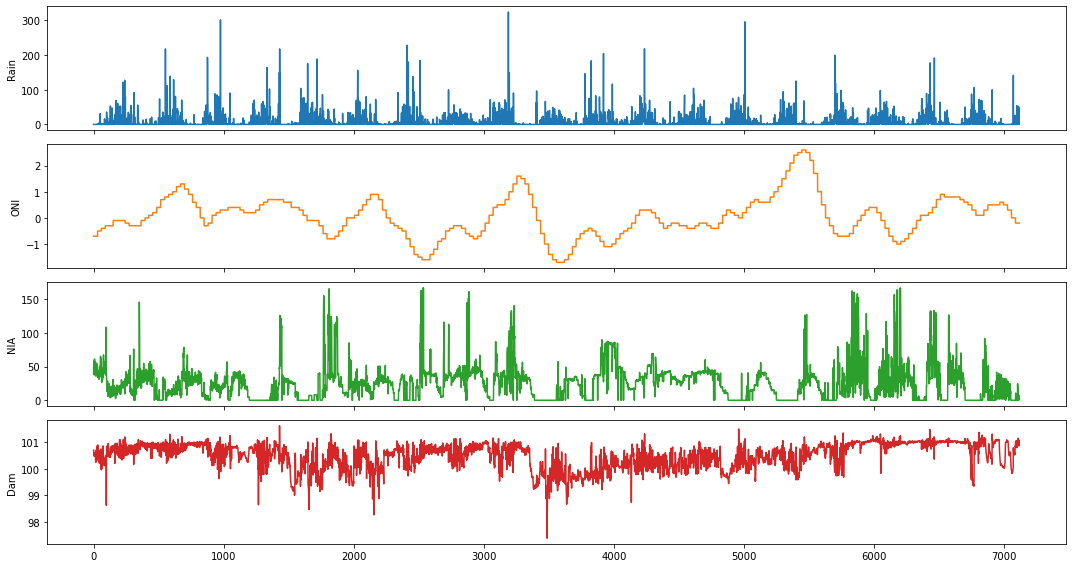

In [3]:
fig,ax = plt.subplots(4, figsize=(15,8), sharex=True)
plot_cols = ['Rain', 'ONI', 'NIA', 'Dam']
ipo_df[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

#### Causality between Rainfall and Ipo Dam Water Level

For this example, we will focus on the Rain and Dam time series.

In [4]:
data_df = ipo_df.drop(['ONI', 'NIA'], axis=1)
data_df.head()

,Rain,Dam
Time,,
0,0.0,100.70
1,0.0,100.63
2,0.0,100.56
3,0.0,100.55
4,0.0,100.48


We look at the lag plots to quickly check for stationarity.

In [5]:
def lag_plots(data_df):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    lag_plot(data_df[data_df.columns[0]], ax=ax1)
    ax1.set_title(data_df.columns[0]);

    lag_plot(data_df[data_df.columns[1]], ax=ax2)
    ax2.set_title(data_df.columns[1]);

    ax1.set_ylabel('$y_{t+1}$');
    ax1.set_xlabel('$y_t$');
    ax2.set_ylabel('$y_{t+1}$');
    ax2.set_xlabel('$y_t$');

    plt.tight_layout()

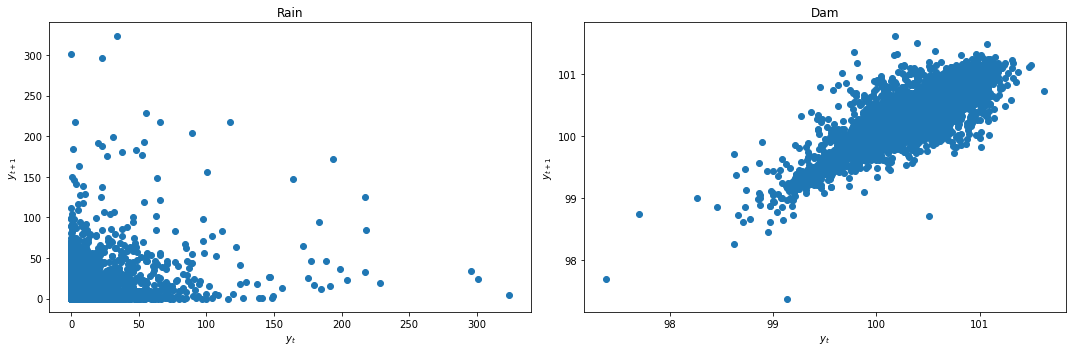

In [6]:
lag_plots(data_df)

**Result:** Dam does not look stationary. Rainfall lag plot is inconclusive.

We use KPSS and ADF tests discussed in the previous chapter to conclusively check for stationarity.

In [7]:
def kpss_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    for c in data_df.columns: 
        kpss_res = kpss(data_df[c].dropna(), regression='ct')
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['2.5%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
    kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

In [8]:
kpss_test(data_df)

,Rain,Dam
Test statistic,0.018,1.8045
p-value,0.100,0.0100
Critical value - 1%,0.216,0.2160
Critical value - 2.5%,0.176,0.1760
Critical value - 5%,0.146,0.1460
Critical value - 10%,0.119,0.1190


**Result:** Rain is stationary, while Dam is not.

In [9]:
def adf_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    for c in data_df.columns: 
        adf_res = adfuller(data_df[c].dropna())
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
    adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    adf_res_df = adf_res_df.round(4)
    return adf_res_df

In [10]:
adf_test(data_df)

,Rain,Dam
Test statistic,-8.6223,-5.8742
p-value,0.0000,0.0000
Critical value - 1%,-3.4313,-3.4313
Critical value - 5%,-2.8619,-2.8619
Critical value - 10%,-2.5670,-2.5670


**Result:** Both data are stationary.

Since both the lag plot and KPSS test indicate that Dam is not stationary, we apply differencing first before building our VAR model.

In [11]:
data_df['Dam'] = data_df['Dam'] - data_df['Dam'].shift(1)
data_df = data_df.dropna()

We again look at the lag plots and apply the KPSS and ADF tests.

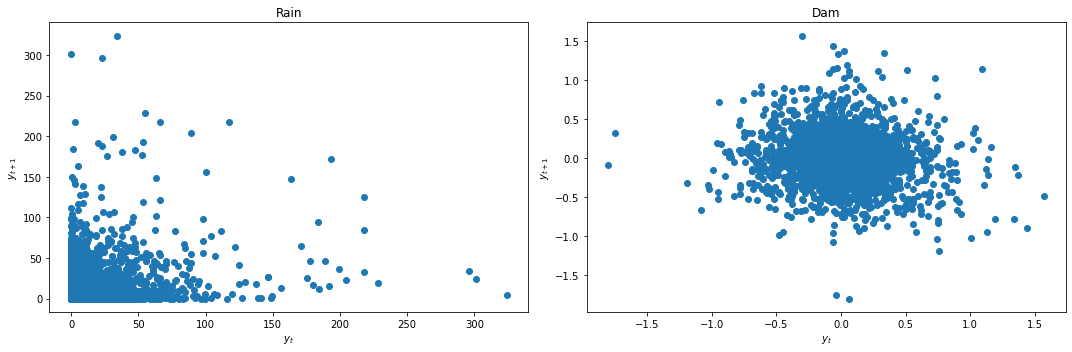

In [12]:
lag_plots(data_df)

In [13]:
kpss_test(data_df)

,Rain,Dam
Test statistic,0.0179,0.0047
p-value,0.1000,0.1000
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


In [14]:
adf_test(data_df)

,Rain,Dam
Test statistic,-8.6227,-21.5919
p-value,0.0000,0.0000
Critical value - 1%,-3.4313,-3.4313
Critical value - 5%,-2.8619,-2.8619
Critical value - 10%,-2.5670,-2.5670


**Result:** All three conclusively agree that both data are now stationary.

We next split the data into train and test sets for the VAR model.

In [15]:
def splitter(data_df):
    end = round(len(data_df)*.8)
    train_df = data_df[:end]
    test_df = data_df[end:]
    return train_df, test_df

In [16]:
train_df, test_df = splitter(data_df)

We then select the VAR order $p$ by computing the different multivariate information criteria (AIC, BIC, HQIC), and FPE.

In [17]:
def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,60)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

AIC     21
BIC      8
HQIC    11
FPE     21
dtype: int64


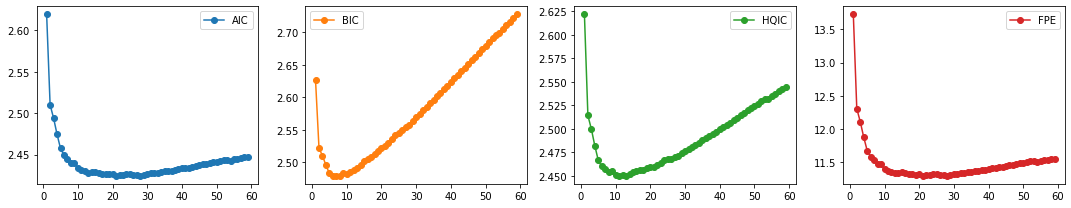

In [18]:
select_p(train_df)

**Result:** We see that BIC has the lowest value at $p=8$ while HQIC  at $p=11$. Although both AIC and FPE have the lowest value at $p=21$, their plots also show an elbow. We can thus select the number of lags to be 8 (also for computational efficiency). 

We now fit the VAR model with the chosen order.

In [19]:
p = 8
model = VAR(train_df)
var_model = model.fit(p)

We can finally test the variables for Granger Causality

In [20]:
def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [21]:
granger_causation_matrix(train_df, train_df.columns, p)  

,Rain_x,Dam_x
Rain_y,1.0,0.2169
Dam_y,0.0,1.0000


**Recall:** If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

**Results:** For this particular example, we can say that rainfall Granger causes changes in the dam water level. This means that rainfall data improves changes in dam water level prediction performance.

On the other hand, changes in dam water level does not Granger cause rainfall. This means that changes in dam water level data does not improve rainfall prediction performance.

#### Causality between NIA Release Flow and Ipo Dam Water Level

In this next example, we now focus on the NIA and Dam time series.

In [22]:
data_df = ipo_df.drop(['ONI', 'Rain'], axis=1)
data_df.head()

,NIA,Dam
Time,,
0,38.225693,100.70
1,57.996530,100.63
2,49.119213,100.56
3,47.034720,100.55
4,42.223380,100.48


We first check for stationarity by looking at the lag plots and applying the KPSS and ADF tests.

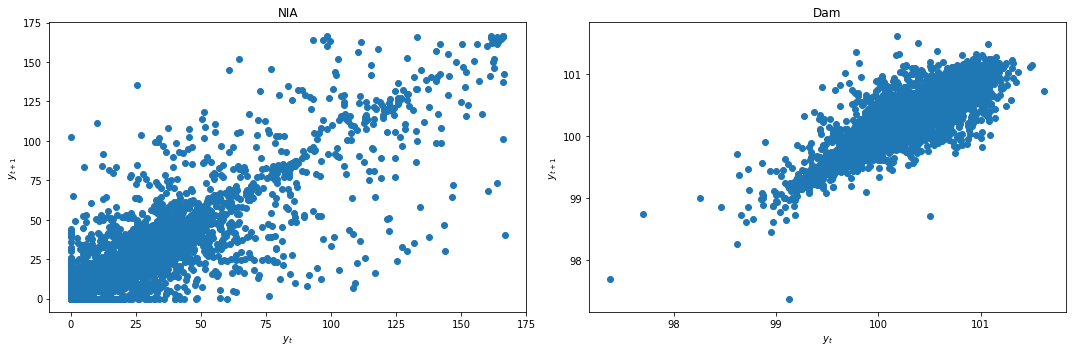

In [23]:
lag_plots(data_df)

In [24]:
kpss_test(data_df)

,NIA,Dam
Test statistic,0.184,1.8045
p-value,0.022,0.0100
Critical value - 1%,0.216,0.2160
Critical value - 2.5%,0.176,0.1760
Critical value - 5%,0.146,0.1460
Critical value - 10%,0.119,0.1190


In [25]:
adf_test(data_df)

,NIA,Dam
Test statistic,-6.6030,-5.8742
p-value,0.0000,0.0000
Critical value - 1%,-3.4313,-3.4313
Critical value - 5%,-2.8619,-2.8619
Critical value - 10%,-2.5670,-2.5670


**Result:** All three conclusively show that both data are not stationary.

We apply differencing and recheck for stationarity.

In [26]:
data_df['NIA'] = data_df['NIA'] - data_df['NIA'].shift(1)
data_df['Dam'] = data_df['Dam'] - data_df['Dam'].shift(1)
data_df = data_df.dropna()

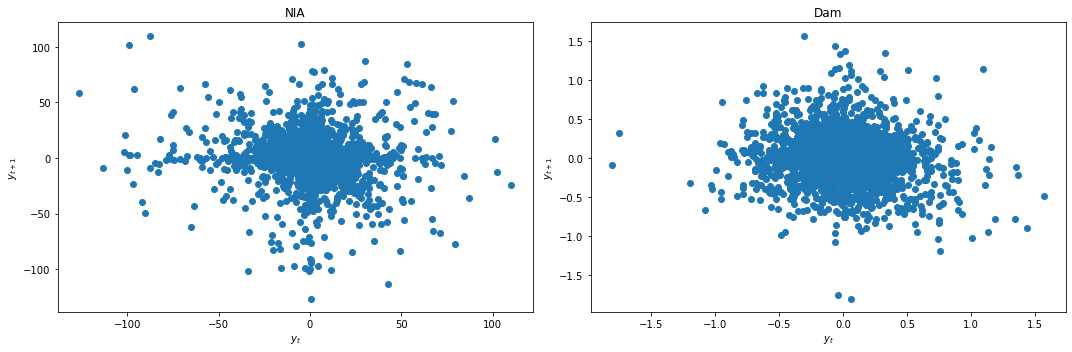

In [27]:
lag_plots(data_df)

In [28]:
kpss_test(data_df)

,NIA,Dam
Test statistic,0.0048,0.0047
p-value,0.1000,0.1000
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


In [29]:
adf_test(data_df)

,NIA,Dam
Test statistic,-21.2837,-21.5919
p-value,0.0000,0.0000
Critical value - 1%,-3.4313,-3.4313
Critical value - 5%,-2.8619,-2.8619
Critical value - 10%,-2.5670,-2.5670


**Result:** All three conclusively agree that both data are now stationary.

We next split the data and select the lag order $p$.

In [30]:
train_df, test_df = splitter(data_df)

AIC     27
BIC      8
HQIC    13
FPE     27
dtype: int64


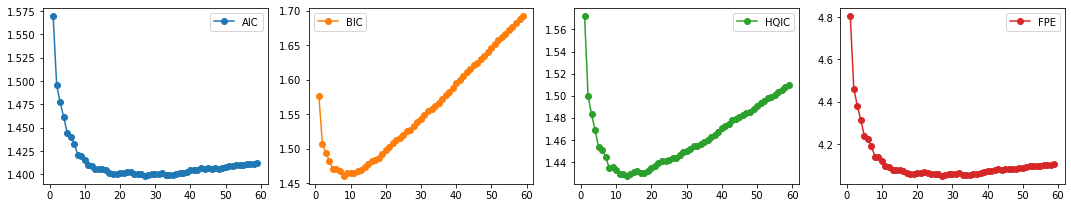

In [31]:
select_p(train_df)

We select $p=8$ with the same reasons as before. We finally fit our VAR model and test for Granger Causality.

In [32]:
p = 8
model = VAR(train_df)
var_model = model.fit(p)

In [33]:
granger_causation_matrix(train_df, train_df.columns, p)  

,NIA_x,Dam_x
NIA_y,1.0000,0.0007
Dam_y,0.0216,1.0000


**Recall:** If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

**Result:** For this particular example, we can say that changes in NIA release flow Granger causes changes in the dam water level. Conversely, changes in dam water level also Granger causes changes in the NIA release flow. This is an example of the feedback mentioned in an earlier section above. This means that NIA release flow data improves changes in dam water level prediction performance, and dam water level data also improves changes in NIA release flow prediction performance.

### Example 2: Causality for La Mesa Dam

We now do the same steps for the La Mesa dataset.

In [34]:
lamesa_df = pd.read_csv('../data/La Mesa_dataset.csv', index_col='Time');
lamesa_df = lamesa_df.dropna()
lamesa_df.head()

,Rain,ONI,NIA,Dam
Time,,,,
0,0.0,-0.7,38.225693,78.63
1,0.0,-0.7,57.996530,78.63
2,0.0,-0.7,49.119213,78.61
3,0.0,-0.7,47.034720,78.59
4,0.0,-0.7,42.223380,78.56


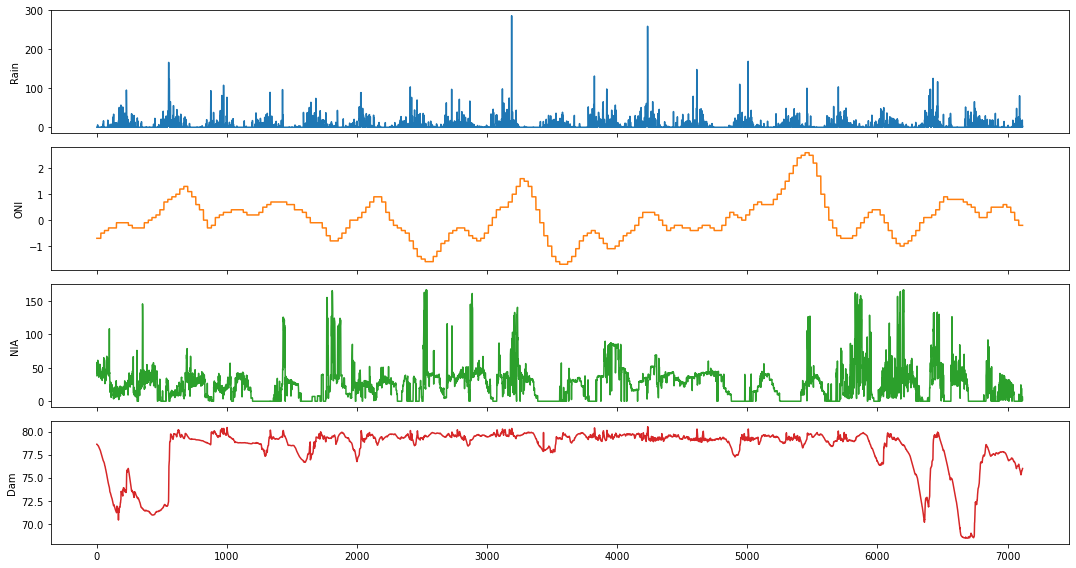

In [35]:
fig,ax = plt.subplots(4, figsize=(15,8), sharex=True)
plot_cols = ['Rain', 'ONI', 'NIA', 'Dam']
lamesa_df[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

#### Causality between Rainfall and La Mesa Dam Water Level

In this next example, we first consider the Rain and Dam time series.

In [36]:
data_df = lamesa_df.drop(['ONI', 'NIA'], axis=1)
data_df.head()

,Rain,Dam
Time,,
0,0.0,78.63
1,0.0,78.63
2,0.0,78.61
3,0.0,78.59
4,0.0,78.56


We first check for stationarity by looking at the lag plots and applying the KPSS and ADF tests.

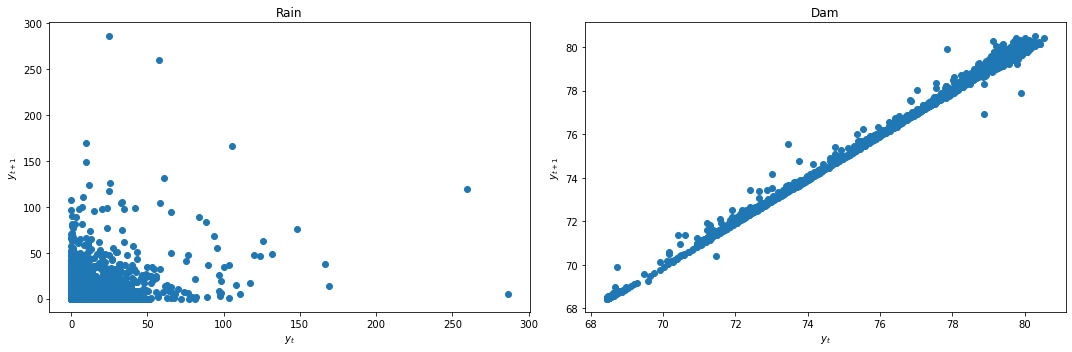

In [37]:
lag_plots(data_df)

In [38]:
kpss_test(data_df)

,Rain,Dam
Test statistic,0.0327,1.8845
p-value,0.1000,0.0100
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


In [39]:
adf_test(data_df)

,Rain,Dam
Test statistic,-8.7136,-4.2004
p-value,0.0000,0.0007
Critical value - 1%,-3.4313,-3.4313
Critical value - 5%,-2.8619,-2.8619
Critical value - 10%,-2.5670,-2.5670


**Result:** All three conclusively show that again Rain is stationary, while Dam is not.

We apply differencing and recheck for stationarity.

In [40]:
data_df['Dam'] = data_df['Dam'] - data_df['Dam'].shift(1)
data_df = data_df.dropna()

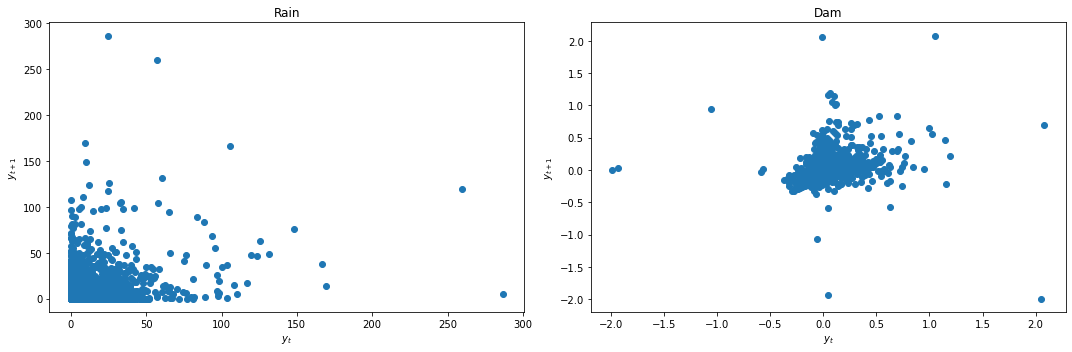

In [41]:
lag_plots(data_df)

In [42]:
kpss_test(data_df)

,Rain,Dam
Test statistic,0.0327,0.0226
p-value,0.1000,0.1000
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


In [43]:
adf_test(data_df)

,Rain,Dam
Test statistic,-8.7138,-26.5948
p-value,0.0000,0.0000
Critical value - 1%,-3.4313,-3.4313
Critical value - 5%,-2.8619,-2.8619
Critical value - 10%,-2.5670,-2.5670


**Result:** All three conclusively agree that both data are now stationary.

We next split the data and select the lag order $p$.

In [44]:
train_df, test_df = splitter(data_df)

AIC     7
BIC     6
HQIC    7
FPE     7
dtype: int64


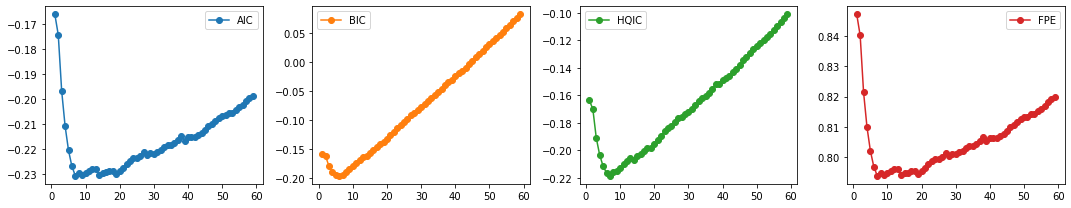

In [45]:
select_p(train_df)

We select $p=7$. We finally fit our VAR model and test for Granger Causality.

In [46]:
p = 7
model = VAR(train_df)
var_model = model.fit(p)

In [47]:
granger_causation_matrix(train_df, train_df.columns, p)  

,Rain_x,Dam_x
Rain_y,1.0,0.0005
Dam_y,0.0,1.0000


**Recall:** If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

**Result:** For this particular example, we can say that rainfall Granger causes changes in the dam water level. Conversely, changes in dam water level also Granger causes rainfall. This is another example of feedback. This means that rainfall data improves changes in dam water level prediction performance, and dam water level data also improves rainfall prediction performance.

#### Causality between NIA Release Flow and La Mesa Dam Water Level

In this next example, we now focus on the NIA and Dam time series.

In [48]:
data_df = lamesa_df.drop(['ONI', 'Rain'], axis=1)
data_df.head()

,NIA,Dam
Time,,
0,38.225693,78.63
1,57.996530,78.63
2,49.119213,78.61
3,47.034720,78.59
4,42.223380,78.56


We first check for stationarity by looking at the lag plots and applying the KPSS and ADF tests.

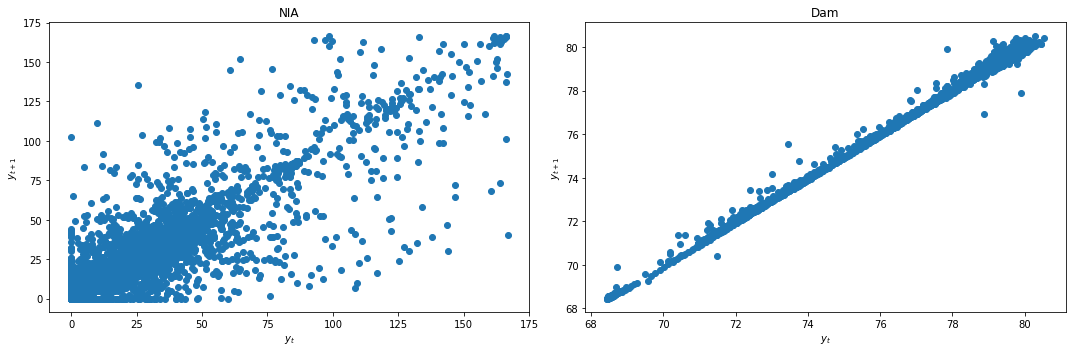

In [49]:
lag_plots(data_df)

In [50]:
kpss_test(data_df)

,NIA,Dam
Test statistic,0.184,1.8845
p-value,0.022,0.0100
Critical value - 1%,0.216,0.2160
Critical value - 2.5%,0.176,0.1760
Critical value - 5%,0.146,0.1460
Critical value - 10%,0.119,0.1190


In [51]:
adf_test(data_df)

,NIA,Dam
Test statistic,-6.6030,-4.2004
p-value,0.0000,0.0007
Critical value - 1%,-3.4313,-3.4313
Critical value - 5%,-2.8619,-2.8619
Critical value - 10%,-2.5670,-2.5670


**Result:** All three conclusively show that both data are not stationary.

We apply differencing and recheck for stationarity.

In [52]:
data_df['NIA'] = data_df['NIA'] - data_df['NIA'].shift(1)
data_df['Dam'] = data_df['Dam'] - data_df['Dam'].shift(1)
data_df = data_df.dropna()

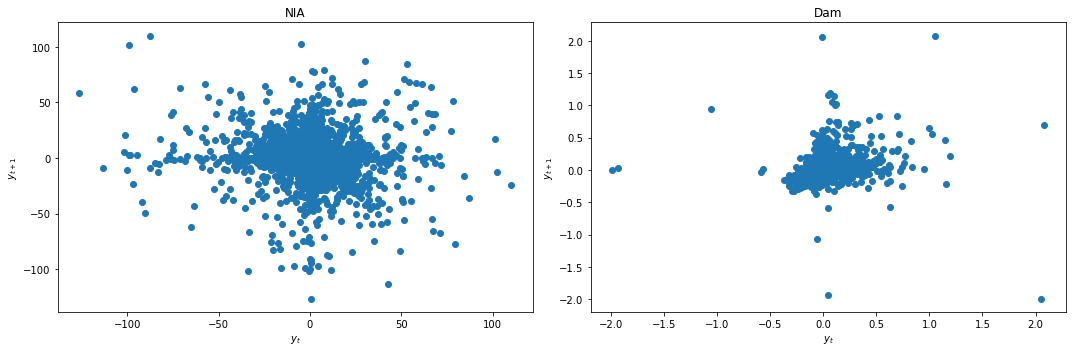

In [53]:
lag_plots(data_df)

In [54]:
kpss_test(data_df)

,NIA,Dam
Test statistic,0.0048,0.0226
p-value,0.1000,0.1000
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


In [55]:
adf_test(data_df)

,NIA,Dam
Test statistic,-21.2837,-26.5948
p-value,0.0000,0.0000
Critical value - 1%,-3.4313,-3.4313
Critical value - 5%,-2.8619,-2.8619
Critical value - 10%,-2.5670,-2.5670


**Result:** All three conclusively agree that both data are now stationary.

We next split the data and select the lag order $p$.

In [56]:
train_df, test_df = splitter(data_df)

AIC     14
BIC      2
HQIC     8
FPE     14
dtype: int64


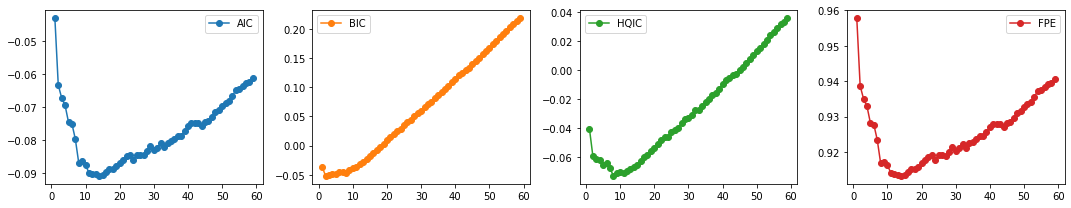

In [57]:
select_p(train_df)

We select $p=14$. We finally fit our VAR model and test for Granger Causality.

In [58]:
p = 14
model = VAR(train_df)
var_model = model.fit(p)

In [59]:
granger_causation_matrix(train_df, train_df.columns, p)  

,NIA_x,Dam_x
NIA_y,1.000,0.1632
Dam_y,0.636,1.0000


**Recall:** If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

**Result:** We see that, unlike for Ipo Dam, changes in NIA release flow and changes in the dam water level do NOT Granger cause one another for La Mesa Dam. This means that NIA release flow data does NOT improve changes in dam water level prediction performance, and dam water level data also does NOT improve changes in NIA release flow prediction performance.

### Exercises

As exercises, the reader can test for Granger Causality between other pairs of variables from both the Ipo and La Mesa datasets, as well as from the Angat dataset.

### Example 3: Jena Climate Data

We look back at the Jena climate dataset and explore which variables are Granger causal to another.

In [64]:
train_df = pd.read_csv('../data/train_series_datetime.csv',index_col=0).set_index('Date Time')
val_df = pd.read_csv('../data/val_series_datetime.csv',index_col=0).set_index('Date Time')
test_df = pd.read_csv('../data/test_series_datetime.csv',index_col=0).set_index('Date Time')
train_df.index = pd.to_datetime(train_df.index)
val_df.index = pd.to_datetime(val_df.index)
test_df.index = pd.to_datetime(test_df.index)

train_val_df = pd.concat([train_df, val_df])
jena_df = pd.concat([train_df, val_df, test_df])
jena_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
2009-01-01 02:10:00,996.63,-8.85,264.57,-9.70,93.5,3.12,2.92,0.20,1.82,2.93,1312.11,0.16,0.50,158.3
2009-01-01 03:10:00,996.87,-8.84,264.56,-9.69,93.5,3.13,2.92,0.20,1.83,2.93,1312.37,0.07,0.25,129.3
2009-01-01 04:10:00,997.05,-9.23,264.15,-10.25,92.2,3.03,2.79,0.24,1.74,2.80,1314.62,0.10,0.38,203.9


#### Causality between Pressure and Temperature

In this next example, we first consider the p and T time series.

In [66]:
data_df = jena_df.iloc[:,:2]
data_df.head()

,p (mbar),T (degC)
Date Time,,
2009-01-01 00:10:00,996.52,-8.02
2009-01-01 01:10:00,996.50,-7.62
2009-01-01 02:10:00,996.63,-8.85
2009-01-01 03:10:00,996.87,-8.84
2009-01-01 04:10:00,997.05,-9.23


We first check for stationarity by looking at the lag plots and applying the KPSS and ADF tests.

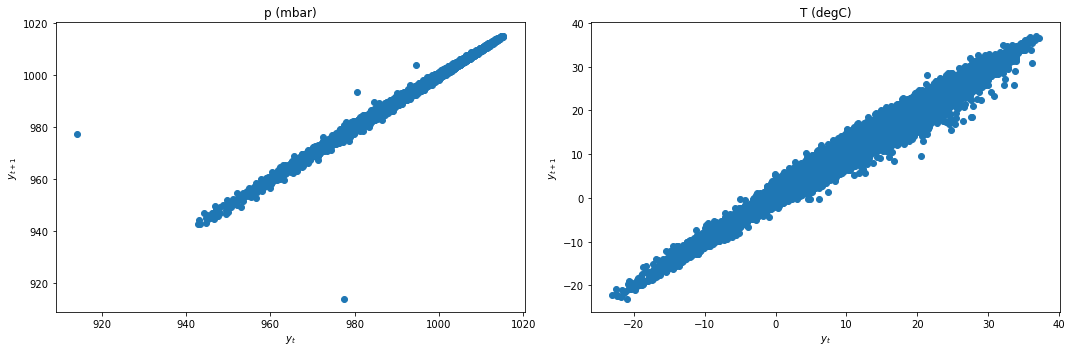

In [67]:
lag_plots(data_df)

In [68]:
kpss_test(data_df)

,p (mbar),T (degC)
Test statistic,0.2295,0.3649
p-value,0.0100,0.0100
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


In [69]:
adf_test(data_df)

,p (mbar),T (degC)
Test statistic,-18.3281,-8.5824
p-value,0.0000,0.0000
Critical value - 1%,-3.4304,-3.4304
Critical value - 5%,-2.8616,-2.8616
Critical value - 10%,-2.5668,-2.5668


**Result:** All three conclusively show that both data are not stationary.

We apply differencing and recheck for stationarity.

In [70]:
data_df['p (mbar)'] = data_df['p (mbar)'] - data_df['p (mbar)'].shift(1)
data_df['T (degC)'] = data_df['T (degC)'] - data_df['T (degC)'].shift(1)
data_df = data_df.dropna()

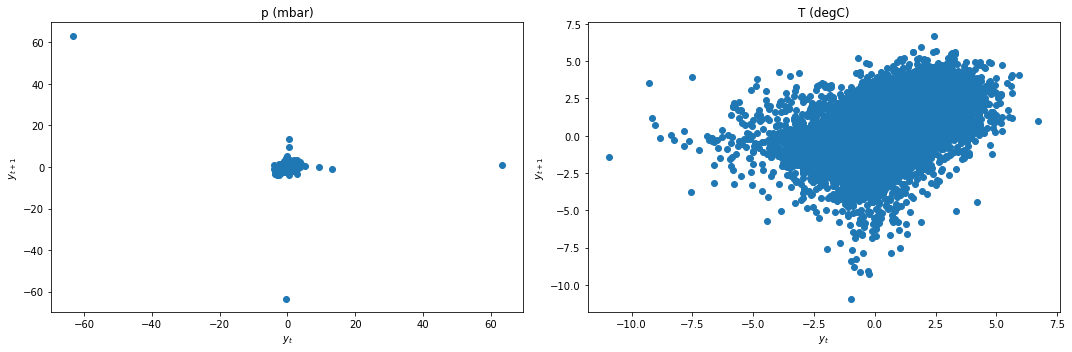

In [71]:
lag_plots(data_df)

In [72]:
kpss_test(data_df)

,p (mbar),T (degC)
Test statistic,0.0009,0.0024
p-value,0.1000,0.1000
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


In [73]:
adf_test(data_df)

,p (mbar),T (degC)
Test statistic,-38.6219,-41.3374
p-value,0.0000,0.0000
Critical value - 1%,-3.4304,-3.4304
Critical value - 5%,-2.8616,-2.8616
Critical value - 10%,-2.5668,-2.5668


**Result:** All three conclusively agree that both data are now stationary.

We next split the data and select the lag order $p$.

In [74]:
train_df, test_df = splitter(data_df)

AIC     59
BIC     53
HQIC    54
FPE     59
dtype: int64


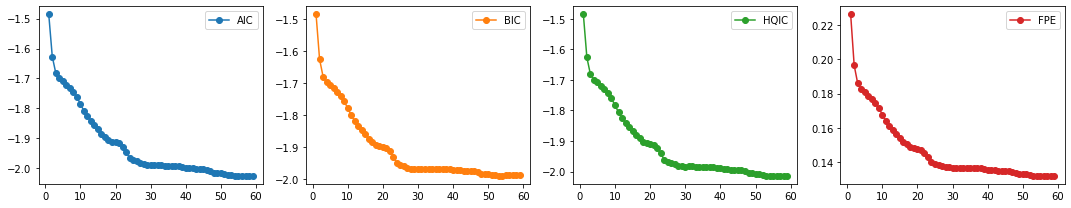

In [75]:
select_p(train_df)

We select $p=30$. We finally fit our VAR model and test for Granger Causality.

In [76]:
p = 30
model = VAR(train_df)
var_model = model.fit(p)

In [77]:
granger_causation_matrix(train_df, train_df.columns, p)  

,p (mbar)_x,T (degC)_x
p (mbar)_y,1.0,0.0
T (degC)_y,0.0,1.0


**Recall:** If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

**Result:** For this particular example, we can say that changes in pressure Granger causes changes in temperature. Conversely, changes in temperature also Granger causes pressure. This is another example of feedback. This means that pressure data improves changes in temperature prediction performance, and temperature data also improves pressure prediction performance.

## Summary

We have introduced the notion of causality in this chapter, and discussed its implications on time series analysis. We also applied the Granger Causality Test for linear VAR models for several datasets, seeing different examples of causality between the variables explored.

Causality will be revisited in a later chapter, in particular addressing the limitations of the method discussed in this chapter and discussing causality for nonlinear models.

## References

The contents of this notebook are compiled from the following references:

* [Granger, C. (1969). Investigating Causal Relations by Econometric Models and Cross-spectral Methods. Econometrica, 37(3), 424-438.](https://www.jstor.org/stable/1912791)
* [Toda, Hiro Y. & Yamamoto, Taku (1995). Statistical inference in vector autoregressions with possibly integrated processes. Journal of Econometrics, 66(1-2), 225-250.](https://ideas.repec.org/a/eee/econom/v66y1995i1-2p225-250.html)
* [Hood, M., Kidd, Q., & Morris, I. (2008). Two Sides of the Same Coin? Employing Granger Causality Tests in a Time Series Cross-Section Framework. Political Analysis, 16(3), 324-344.](https://www.jstor.org/stable/25791939)
* [Testing for Granger Causality Using Python](https://rishi-a.github.io/2020/05/25/granger-causality.html)